This notebook aims at comparing multiples LSTM models

Library imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

Data import

In [15]:
filepath = './data/export_infoclimat_filtered.csv'

df = pd.read_csv(filepath)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1044 non-null   object 
 1   temperature  1044 non-null   float64
 2   humidite     1044 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.6+ KB
None
                  date  temperature  humidite
0  2025-10-04 03:00:00         14.7        96
1  2025-10-04 03:10:00         14.4        97
2  2025-10-04 03:20:00         14.3        97
3  2025-10-04 03:30:00         14.1        97
4  2025-10-04 03:40:00         14.0        97


In [16]:
numeric_cols = ['temperature']
data_selected = df[numeric_cols]
data_selected.shape

(1044, 1)

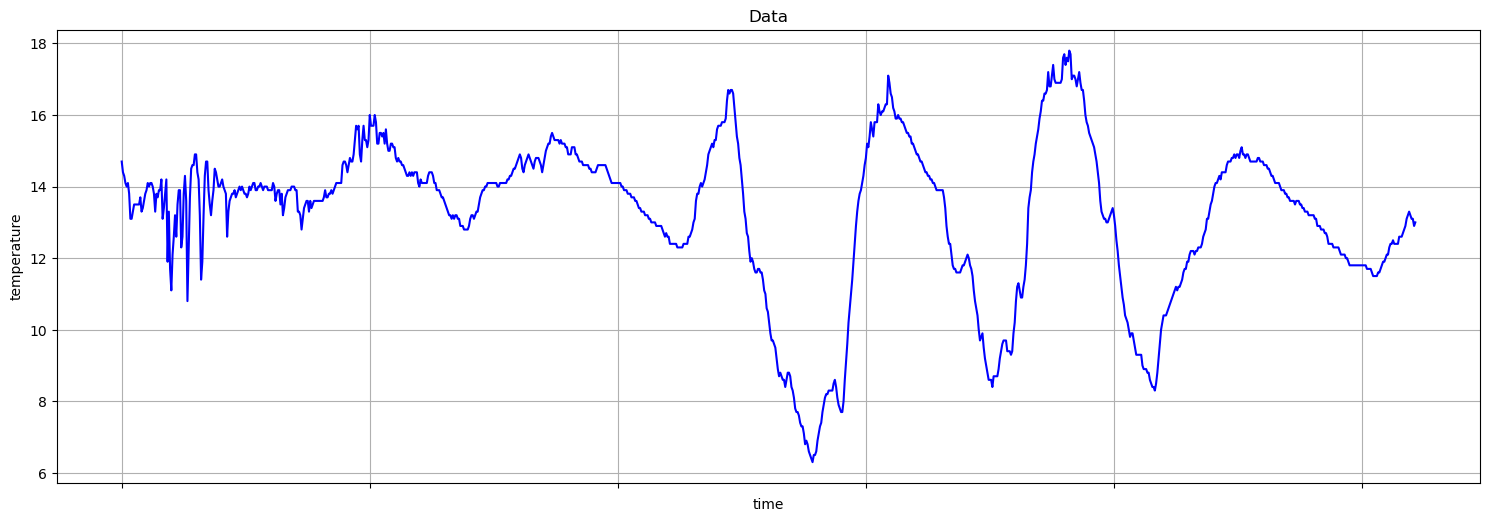

In [17]:
colors = ['blue', 'green']
n_features = len(colors)
plt.figure(figsize=(15, 10))

for i, (feature, color) in enumerate(zip(data_selected.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)
    data_selected[feature].plot(ax=ax, color=color)
    ax.set_title("Data")
    ax.set_xlabel('time')
    ax.set_ylabel(feature)
    ax.grid(True)

    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

Data split between training and testing set

In [18]:
train_size = int(len(data_selected) * .85)
train_data = data_selected[:train_size]
test_data = data_selected[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (887, 1)
Test data shape: (157, 1)


In [19]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create sequences for LSTM - Version améliorée
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 48  # 48 half-hours = 1 day
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (839, 48, 1)
y_train shape: (839, 1)
X_test shape: (109, 48, 1)
y_test shape: (109, 1)


In [20]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Creation of multiple models with different configurations

In [21]:
models_configs = []

# Configuration 1: Small model, low learning rate
model1 = Sequential([
    LSTM(8, return_sequences=False, dropout=0.1, recurrent_dropout=0.1, input_shape=(seq_length, 1)),
    Dense(4, activation='relu'),
    Dense(1)
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'Small_LR0.0005',
    'model': model1,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001, verbose=0)
    ]
})

# Configuration 2: Medium model, standard learning rate
model2 = Sequential([
    LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, input_shape=(seq_length, 1)),
    Dense(8, activation='relu'),
    Dense(1)
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'Medium_LR0.001',
    'model': model2,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0005, verbose=0)
    ]
})

# Configuration 3: Large model, higher learning rate
model3 = Sequential([
    LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3, input_shape=(seq_length, 1)),
    Dense(16, activation='relu'),
    Dense(1)
])
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'Large_LR0.002',
    'model': model3,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, min_lr=0.001, verbose=0)
    ]
})

# Configuration 4: Deep model, low dropout
model4 = Sequential([
    LSTM(24, return_sequences=False, dropout=0.1, recurrent_dropout=0.1, input_shape=(seq_length, 1)),
    Dense(12, activation='relu'),
    Dense(6, activation='relu'),
    Dense(1)
])
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'Deep_LowDropout',
    'model': model4,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=0.0001, verbose=0)
    ]
})

# Configuration 5: Very small model, aggressive learning
model5 = Sequential([
    LSTM(4, return_sequences=False, dropout=0.0, recurrent_dropout=0.0, input_shape=(seq_length, 1)),
    Dense(1)
])
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'VerySmall_LR0.003',
    'model': model5,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    ]
})

# Configuration 6: Bidirectional LSTM
model6 = Sequential([
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0.2), input_shape=(seq_length, 1)),
    Dense(8, activation='relu'),
    Dense(1)
])
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'Bidirectional_LR0.001',
    'model': model6,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0005, verbose=0)
    ]
})

# Configuration 7: Stacked LSTM
model7 = Sequential([
    LSTM(20, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(seq_length, 1)),
    LSTM(10, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(5, activation='relu'),
    Dense(1)
])
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'Stacked_LSTM_LR0.0008',
    'model': model7,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.0002, verbose=0)
    ]
})

# Configuration 8: Medium with L2 regularization
model8 = Sequential([
    LSTM(12, return_sequences=False, dropout=0.15, recurrent_dropout=0.15, 
         kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(seq_length, 1)),
    Dense(6, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1)
])
model8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
models_configs.append({
    'name': 'Medium_L2_LR0.0005',
    'model': model8,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=0)
    ]
})
print(f"Created {len(models_configs)} model configurations")
for config in models_configs:
    print(f"- {config['name']}")

/home/pc/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Created 8 model configurations
- Small_LR0.0005
- Medium_LR0.001
- Large_LR0.002
- Deep_LowDropout
- VerySmall_LR0.003
- Bidirectional_LR0.001
- Stacked_LSTM_LR0.0008
- Medium_L2_LR0.0005


/home/pc/.local/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
results = []

for config in models_configs:
    print(f"\n{'='*60}")
    print(f"Training model: {config['name']}")
    print(f"{'='*60}")
    
    history = config['model'].fit(
        X_train, y_train,
        batch_size=16,
        epochs=100,
        validation_split=0.2,
        callbacks=config['callbacks'],
        verbose=1,
        shuffle=True
    )
    
    # Evaluate
    test_loss, test_mae = config['model'].evaluate(X_test, y_test, verbose=0)
    
    results.append({
        'name': config['name'],
        'model': config['model'],
        'history': history,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'final_val_loss': min(history.history['val_loss'])
    })
    
    print(f"\nTest Loss: {test_loss:.6f}")
    print(f"Test MAE: {test_mae:.6f}")
    print(f"Best Val Loss: {min(history.history['val_loss']):.6f}")

# Display summary
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
for result in results:
    print(f"{result['name']:20} | Test MAE: {result['test_mae']:.6f} | Val Loss: {result['final_val_loss']:.6f}")

# best ??
best_result = min(results, key=lambda x: x['test_mae'])
model = best_result['model']
history = best_result['history']
print(f"\nBest model: {best_result['name']} (Test MAE: {best_result['test_mae']:.6f})")


Training model: Small_LR0.0005
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.3863 - mae: 0.5891 - val_loss: 0.3251 - val_mae: 0.5206 - learning_rate: 5.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2962 - mae: 0.5122 - val_loss: 0.2578 - val_mae: 0.4556 - learning_rate: 5.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2205 - mae: 0.4367 - val_loss: 0.1802 - val_mae: 0.3676 - learning_rate: 5.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1354 - mae: 0.3352 - val_loss: 0.0931 - val_mae: 0.2480 - learning_rate: 5.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0578 - mae: 0.2112 - val_loss: 0.0453 - val_mae: 0.1712 - learning_rate: 5.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0305 - mae: 0.1351 - val_loss: 0.0425 - val_mae: 0.1797 - learning_rate: 5.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0313 - mae: 0.1333 - val_loss:

Training history

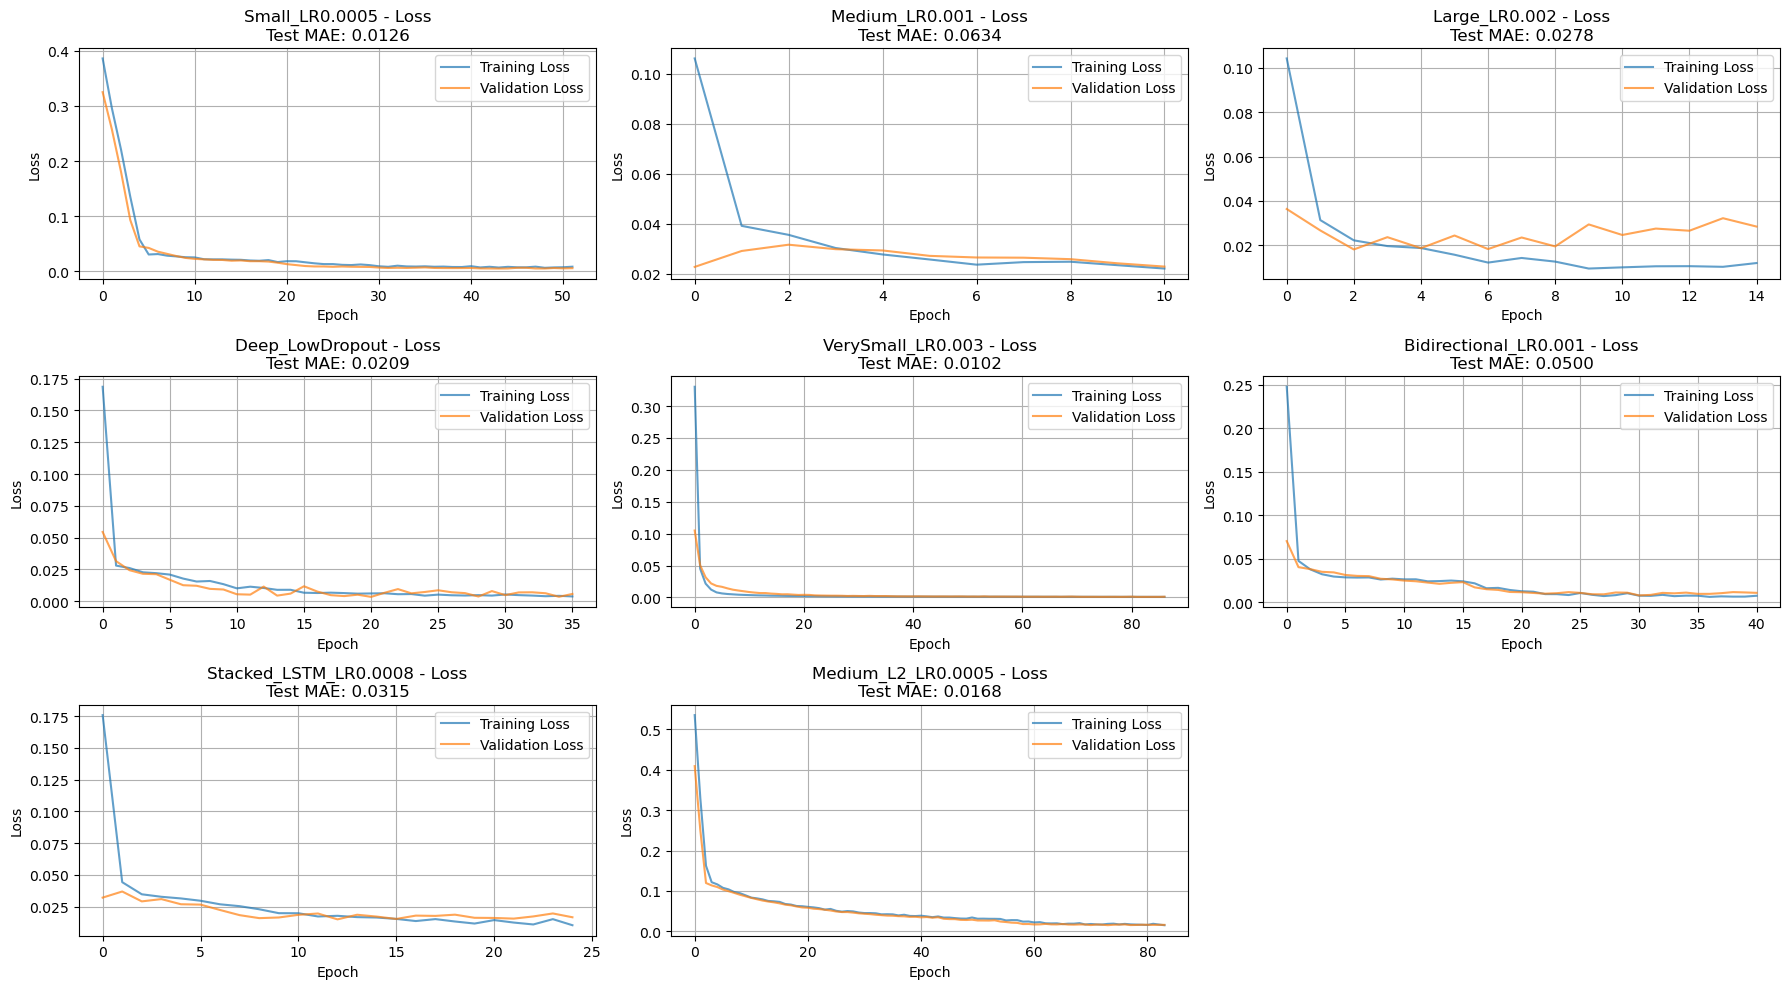

In [23]:
plt.figure(figsize=(18, 10))

for idx, result in enumerate(results, 1):
    plt.subplot(3, 3, idx)
    plt.plot(result['history'].history['loss'], label='Training Loss', alpha=0.7)
    plt.plot(result['history'].history['val_loss'], label='Validation Loss', alpha=0.7)
    plt.title(f"{result['name']} - Loss\nTest MAE: {result['test_mae']:.4f}")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Metrics

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics for all models
print(f"\n{'='*80}")
print("DETAILED METRICS FOR ALL MODELS")
print(f"{'='*80}\n")

for result in results:
    # Get predictions for this model
    predictions = result['model'].predict(X_test, verbose=0)
    pred_denorm = scaler.inverse_transform(predictions).flatten()
    y_test_denorm = scaler.inverse_transform(y_test).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_denorm, pred_denorm)
    mae = mean_absolute_error(y_test_denorm, pred_denorm)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_denorm, pred_denorm)
    
    print(f"Model: {result['name']}")
    # print(f"  MSE:  {mse:.6f}")
    # print(f"  MAE:  {mae:.6f}")
    # print(f"  RMSE: {rmse:.6f}")
    print(f"  R²:   {r2:.6f}")
    print()


DETAILED METRICS FOR ALL MODELS

Model: Small_LR0.0005
  R²:   0.909901

Model: Medium_LR0.001
  R²:   -0.386245

Model: Large_LR0.002
  R²:   0.709499

Model: Deep_LowDropout
  R²:   0.857061

Model: VerySmall_LR0.003
  R²:   0.962823

Model: Bidirectional_LR0.001
  R²:   0.286385

Model: Stacked_LSTM_LR0.0008
  R²:   0.609597

Model: Medium_L2_LR0.0005
  R²:   0.854438



Auto-Recursive Predictions (the model reuses its own outputs as inputs)

In [25]:
def predict_recursive(model, initial_sequence, n_steps, scaler):

    current_seq = initial_sequence.copy().reshape(-1, 1)  # (seq_length, 1)
    predictions = []
    
    for _ in range(n_steps):
        # Predict next step
        current_input = current_seq.reshape(1, len(current_seq), 1)  # (1, seq_length, 1)
        next_pred = model.predict(current_input, verbose=0)[0, 0]
        
        # Stock prediction
        predictions.append(next_pred)
        
        # Update sequence : delete the first timestep and add the new one
        current_seq = np.vstack([current_seq[1:], [[next_pred]]])
    
    # Denormalize predictions
    predictions = np.array(y_test).reshape(-1, 1)
    predictions_denorm = scaler.inverse_transform(predictions).flatten()
    
    return predictions_denorm

Small_LR0.0005            | Temperature 20 steps ahead: 10.71°C
Medium_LR0.001            | Temperature 20 steps ahead: 13.82°C
Large_LR0.002             | Temperature 20 steps ahead: 12.23°C
Deep_LowDropout           | Temperature 20 steps ahead: 14.33°C
VerySmall_LR0.003         | Temperature 20 steps ahead: 15.28°C
Bidirectional_LR0.001     | Temperature 20 steps ahead: 8.94°C
Stacked_LSTM_LR0.0008     | Temperature 20 steps ahead: 11.13°C
Medium_L2_LR0.0005        | Temperature 20 steps ahead: 11.16°C


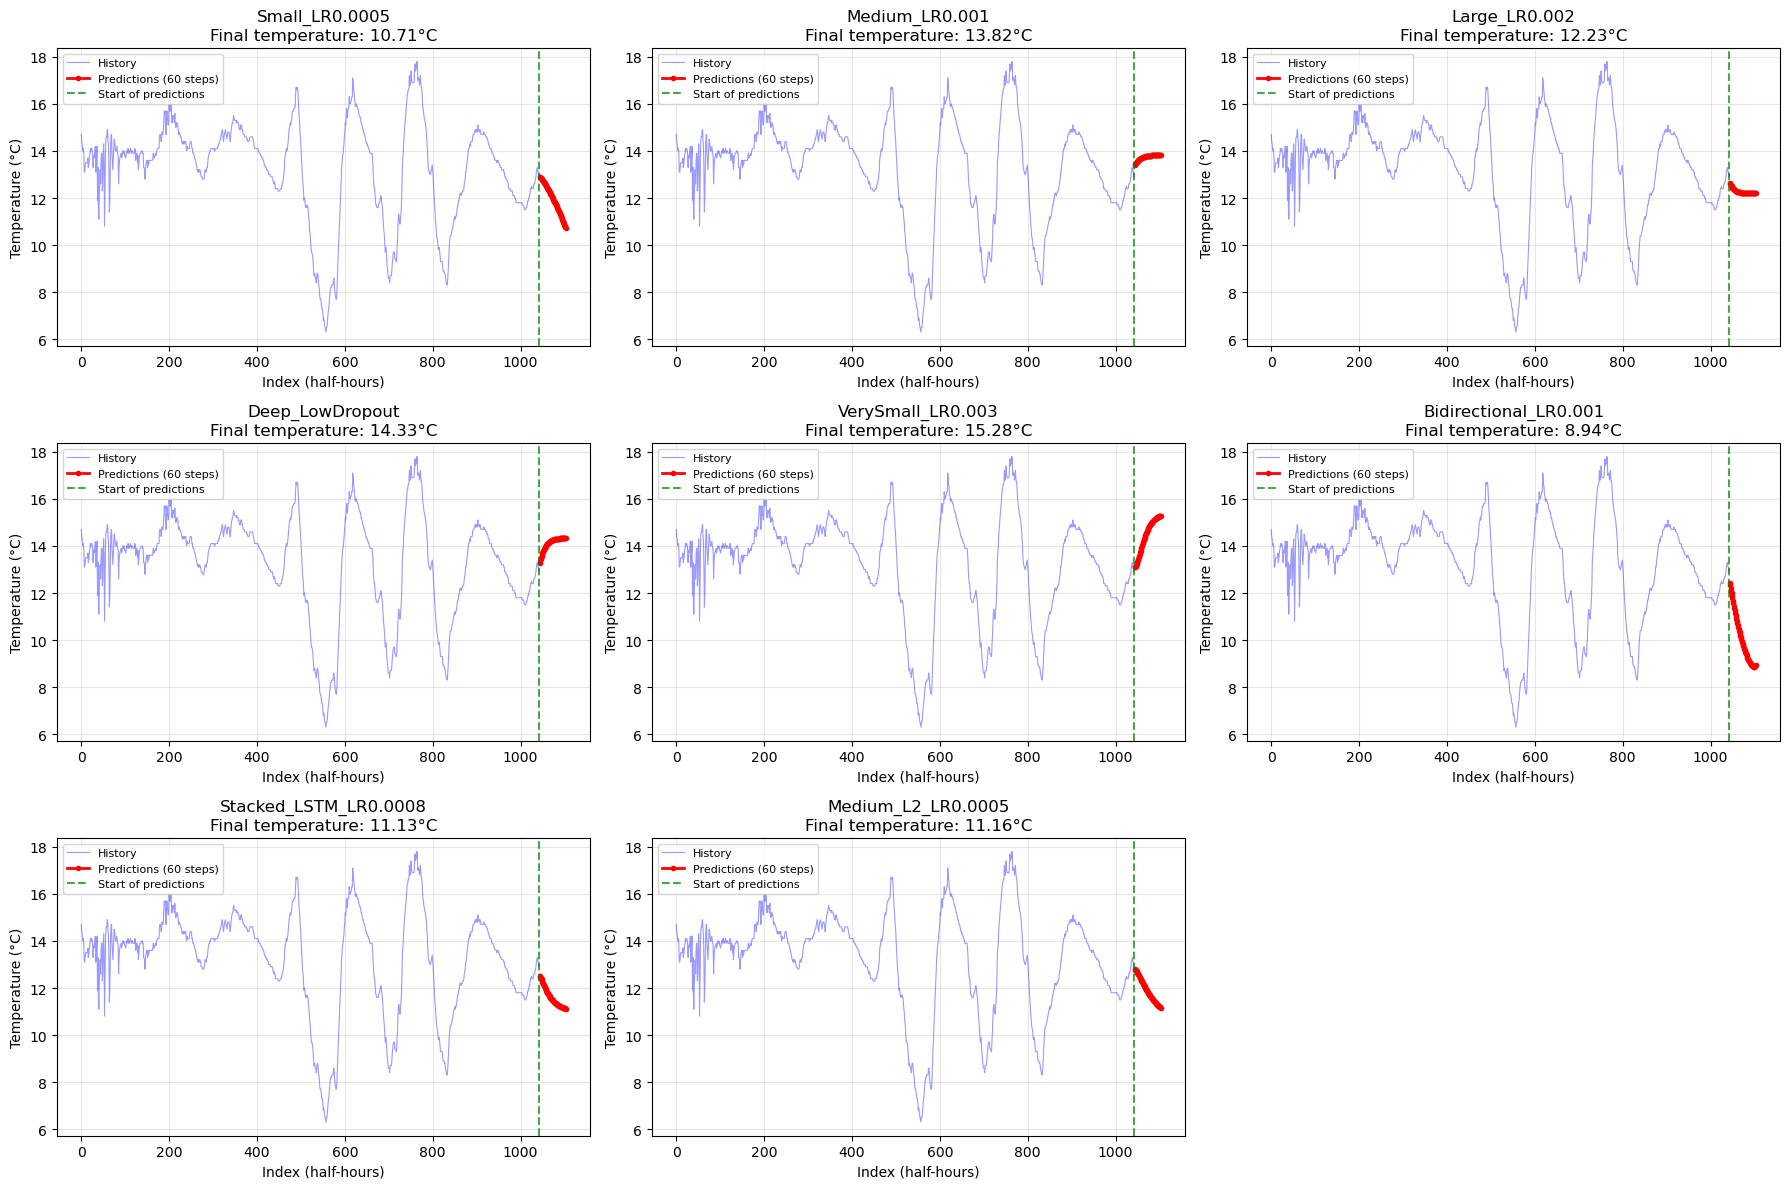

In [26]:
# Recursive predictions for all models
plt.figure(figsize=(18, 12))

for idx, result in enumerate(results, 1):
    # Prédiction récursive pour ce modèle
    initial_seq = test_scaled[-seq_length:]
    n_future_steps = 60
    
    current_seq = initial_seq.copy().reshape(-1, 1)
    predictions_model = []
    
    for _ in range(n_future_steps):
        current_input = current_seq.reshape(1, len(current_seq), 1)
        next_pred = result['model'].predict(current_input, verbose=0)[0, 0]
        predictions_model.append(next_pred)
        current_seq = np.vstack([current_seq[1:], [[next_pred]]])
    
    # Denormalize
    predictions_model = np.array(predictions_model).reshape(-1, 1)
    predictions_denorm = scaler.inverse_transform(predictions_model).flatten()
    
    # Indices for the display
    start_recursive_idx = len(data_selected)
    recursive_indices = np.arange(start_recursive_idx, start_recursive_idx + len(predictions_denorm))
    
    # Display
    plt.subplot(3, 3, idx)
    plt.plot(np.arange(len(data_selected)), data_selected['temperature'].values, 
             label='History', color='blue', alpha=0.4, linewidth=0.8)
    plt.plot(recursive_indices, predictions_denorm, 
             label=f'Predictions ({n_future_steps} steps)', 
             color='red', marker='o', markersize=3, linestyle='-', linewidth=2)
    plt.axvline(x=len(data_selected)-1, color='green', linestyle='--', alpha=0.7,
                label='Start of predictions')
    plt.title(f"{result['name']}\nFinal temperature: {predictions_denorm[-1]:.2f}°C")
    plt.xlabel('Index (half-hours)')
    plt.ylabel('Temperature (°C)')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Print last predicted values
    print(f"{result['name']:25} | Temperature 20 steps ahead: {predictions_denorm[-1]:.2f}°C")

plt.tight_layout()
plt.show()

The VerySmall_LR0.003 model seems to perform quite well compared to others